In [51]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, classification_report
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


import joblib
import warnings
warnings.filterwarnings('ignore')

###### Loading Train Dataset

In [52]:
df=pd.read_csv('train-m.csv') 

In [53]:
print('No. of Rows :',df.shape[0])
print('No. of Columns :',df.shape[1])
pd.set_option('display.max_columns',None) 
df.head()

No. of Rows : 159571
No. of Columns : 8


,id,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


Data set consist of 159571 rows and 8 columns.

In [54]:
# Sorting out columns for datatypes
df.columns.to_series().groupby(df.dtypes).groups

{int64: ['malignant', 'highly_malignant', 'rude', 'threat', 'abuse', 'loathe'], object: ['id', 'comment_text']}

###### Loading Test Dataset

In [55]:
dft=pd.read_csv('test-m.csv')

In [56]:
print('No. of Rows :',dft.shape[0])
print('No. of Columns :',dft.shape[1])
pd.set_option('display.max_columns',None) 
dft.head()

No. of Rows : 153164
No. of Columns : 2


,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


###### Missing Value Check

In [57]:
df.isnull().sum().any()

False

In [58]:
dft.isnull().sum().any()

False

###### Exploration of Target Variables

In [59]:
Categorical = ['malignant', 'highly_malignant', 'rude', 'threat', 'abuse', 'loathe']

In [60]:
for i in df.columns[2:]:
    print('Value Counts of',i)
    print(df[i].value_counts())
    print('='*100)

Value Counts of malignant
0    144277
1     15294
Name: malignant, dtype: int64
Value Counts of highly_malignant
0    157976
1      1595
Name: highly_malignant, dtype: int64
Value Counts of rude
0    151122
1      8449
Name: rude, dtype: int64
Value Counts of threat
0    159093
1       478
Name: threat, dtype: int64
Value Counts of abuse
0    151694
1      7877
Name: abuse, dtype: int64
Value Counts of loathe
0    158166
1      1405
Name: loathe, dtype: int64


imbalanced dataset and we need to handle them

# EDA

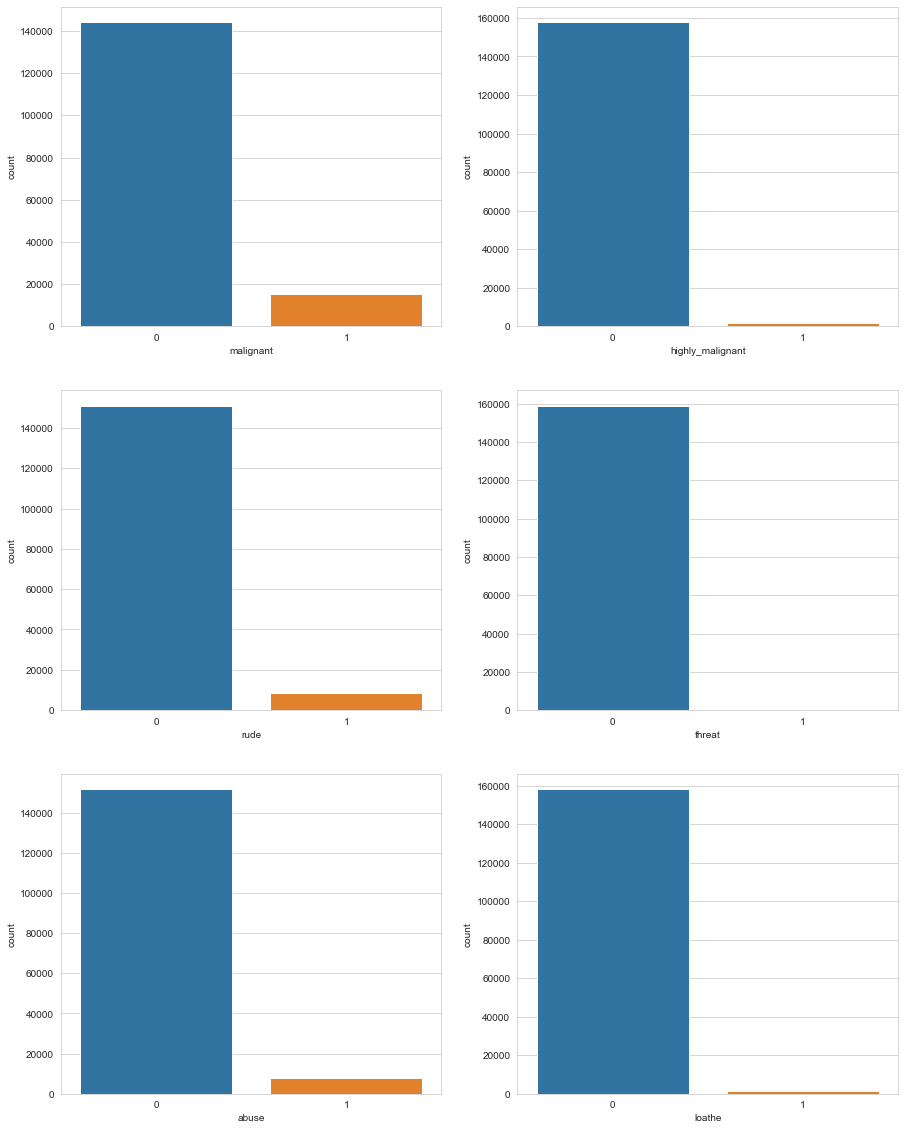

In [61]:
# Plotting countplot for all the features
categories=df.columns[2:]
plt.figure(figsize=(15,20))
plotnumber=1
for col in categories:
    if plotnumber<=6:
        ax=plt.subplot(3,2,plotnumber)
        sns.countplot(df[col])
        plt.xlabel(col,fontsize=10)
        plt.xticks(fontsize=10)
        plt.yticks(fontsize=10)
    plotnumber += 1
plt.show()

maximum Negative comments categories belong to Malignant, a lot of comments are abusive and rude as well

In [62]:
#Checking the percentage of the comments
none = df[(df['malignant']!=1) & (df['highly_malignant']!=1) & (df['rude']!=1) & 
                            (df['threat']!=1) & (df['abuse']!=1) & (df['loathe']!=1)]
percent=len(none)/len(df)*100
print('Percentage of good/neutral comments = ',percent)
print('Percentage of negative comments = ', (100-percent))

Percentage of good/neutral comments =  89.83211235124176
Percentage of negative comments =  10.167887648758239


89.83% comments are Good/Neutral in nature while rest 10.16% comments are Negative in nature.

In [63]:
#Create a new subset of the data by only taking the 2nd column onwards (comments and categories)
data_count = df.iloc[:,2:].sum()

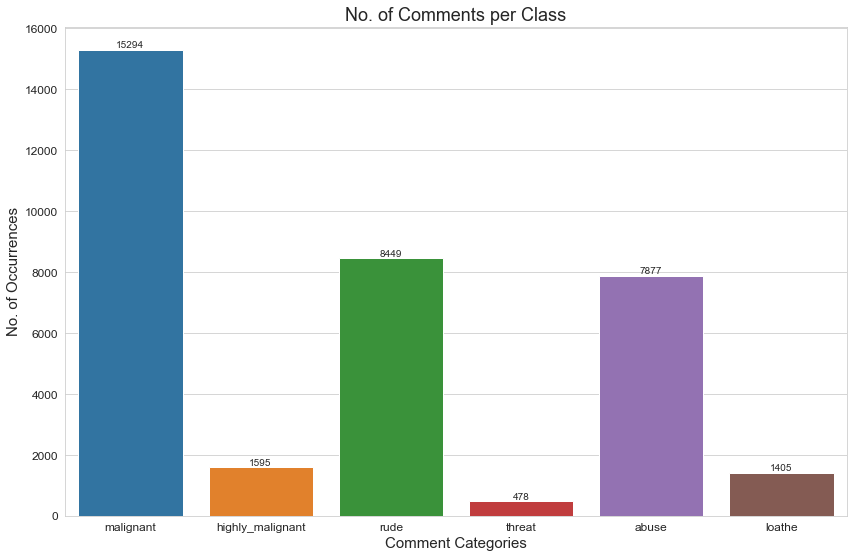

In [64]:
# Plot a chart with the following size
plt.figure(figsize=(14,9))

# Plot a bar chart using the index (category values) and the count of each category.
ax = sns.barplot(data_count.index, data_count.values)

plt.title("No. of Comments per Class", fontsize=18)
plt.ylabel('No. of Occurrences', fontsize=15)
plt.xlabel('Comment Categories', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
rects = ax.patches
labels = data_count.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
plt.show()

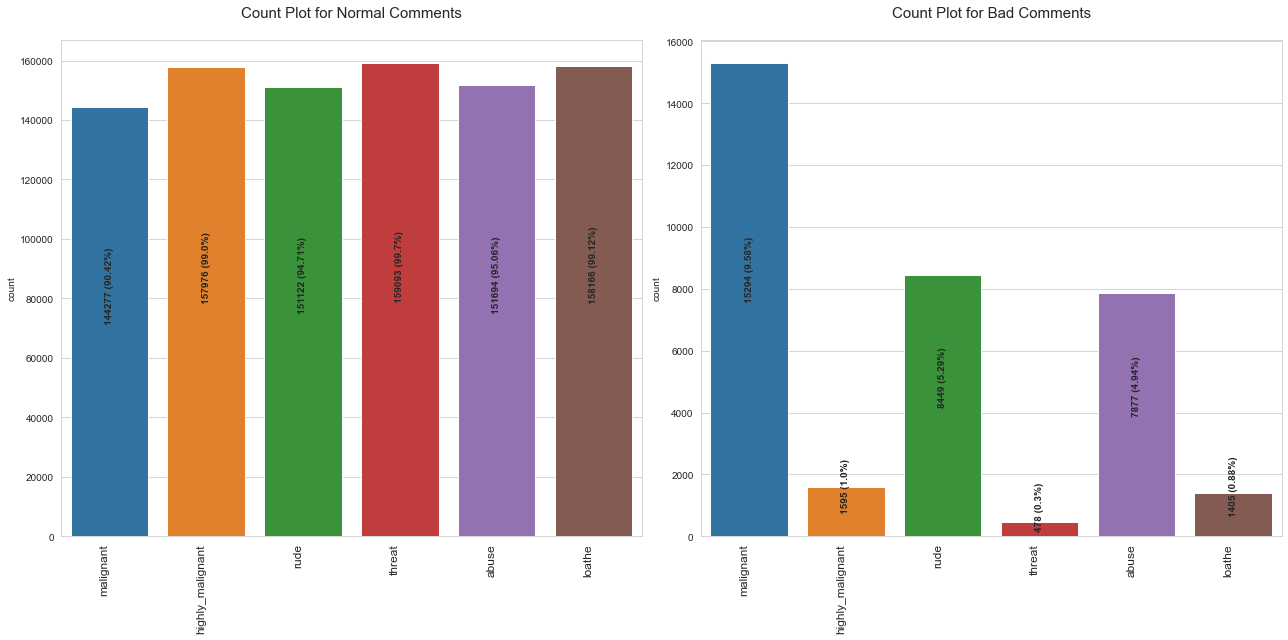

In [65]:
# comparing normal comments and bad comments using count plot

fig, ax = plt.subplots(1,2,figsize=(18,9))

for i in range(2):
    sns.countplot(data=df[df.columns[2:]][df[df.columns[2:]]==i], ax=ax[i])
    if i == 0:
        ax[i].set_title("Count Plot for Normal Comments\n", fontsize=15)
    else:
        ax[i].set_title("Count Plot for Bad Comments\n", fontsize=15)
        
    ax[i].set_xticklabels(df.columns[2:], rotation=90, ha="right", fontsize=12)
    p=0
    for prop in ax[i].patches:
        count = prop.get_height()
        s = f"{count} ({round(count*100/len(df),2)}%)"
        ax[i].text(p,count/2,s,rotation=90, ha="center", fontweight="bold")
        p += 1
plt.tight_layout()
plt.show()

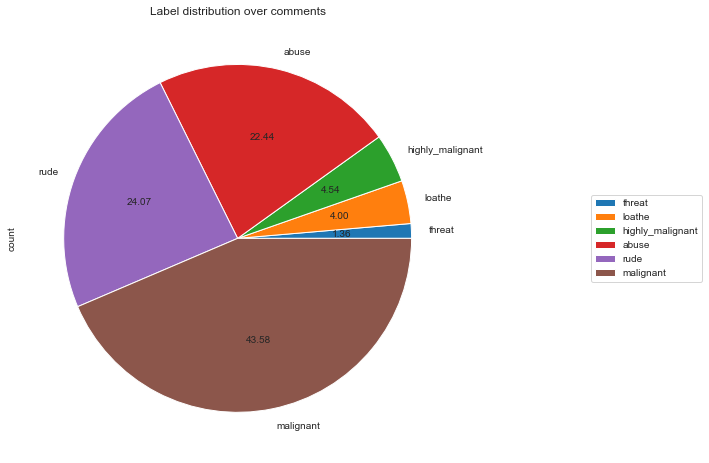

In [66]:
#Visualizing the label distribution of comments using pie chart
comments_labels = ['malignant', 'highly_malignant', 'rude', 'threat', 'abuse', 'loathe']
df_distribution = df[df.columns[2:]].sum()\
                            .to_frame()\
                            .rename(columns={0: 'count'})\
                            .sort_values('count')

df_distribution.plot.pie(y = 'count', title = 'Label distribution over comments',
                         autopct='%2.2f', figsize = (8,8))\
                            .legend(loc='center left', bbox_to_anchor=(1.3, 0.5))
plt.show()

In [67]:
comment_len = df.comment_text.str.len()
df.comment_text.str.len().median()

205.0

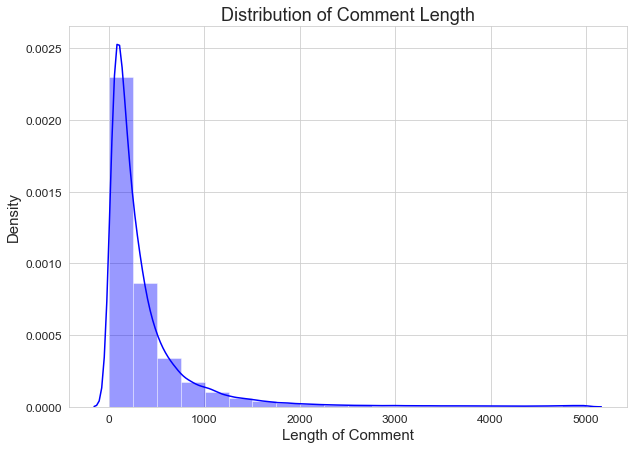

In [68]:
#Distribution of comments length
sns.set_style('whitegrid')
plt.figure(figsize=(10,7))
comment_len = df.comment_text.str.len()
sns.distplot(comment_len, bins=20, color = 'blue')

plt.title("Distribution of Comment Length", fontsize=18)
plt.ylabel('Density', fontsize=15)
plt.xlabel('Length of Comment', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

 most of the comments are short with only a few comments longer than 1000 words. Majority of the comments are of length 500, where maximum length is 5000 and minimum length is 5. Median length being 250.*

In [69]:
#Checking correlation of the dataset
corr=df.corr()  
corr

,malignant,highly_malignant,rude,threat,abuse,loathe
malignant,1.000000,0.308619,0.676515,0.157058,0.647518,0.266009
highly_malignant,0.308619,1.000000,0.403014,0.123601,0.375807,0.201600
rude,0.676515,0.403014,1.000000,0.141179,0.741272,0.286867
threat,0.157058,0.123601,0.141179,1.000000,0.150022,0.115128
abuse,0.647518,0.375807,0.741272,0.150022,1.000000,0.337736
loathe,0.266009,0.201600,0.286867,0.115128,0.337736,1.000000


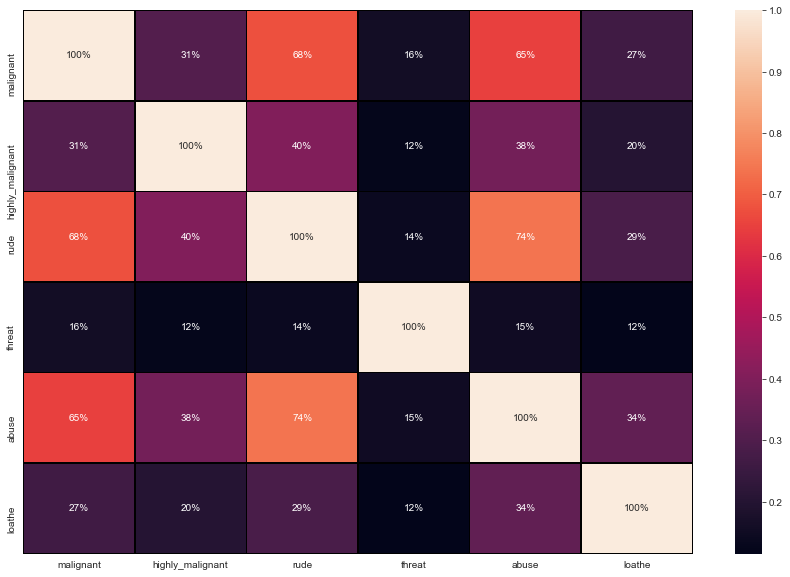

In [70]:
# visualizing the correlation
plt.figure(figsize=(15, 10))
corr = df.corr()
sns.heatmap(corr, linewidth=0.5, linecolor='black', fmt='.0%', annot=True)
plt.show()

# Data pre-processing

In [71]:
#As ID is not much important, we can drop from the dataset
df.drop('id',axis=1,inplace=True)
dft.drop('id',axis=1,inplace=True)

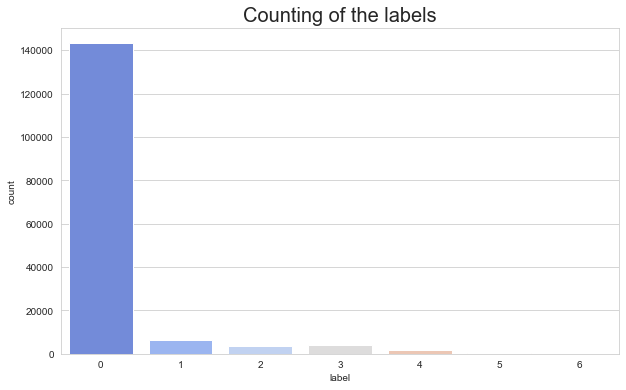

In [72]:
#Checking the count of labels
df['label']=df[comments_labels].sum(axis=1)
plt.figure(figsize=(10,6))
sns.countplot(df['label'], palette='coolwarm')
plt.title('Counting of the labels',fontsize=20)
plt.show()

In [73]:
df['length_before_cleaning'] = df['comment_text'].map(lambda comment_text: len(comment_text))
df

,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe,label,length_before_cleaning
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0,264
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0,112
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0,233
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0,622
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0,67
...,...,...,...,...,...,...,...,...,...
159566,""":::::And for the second time of asking, when ...",0,0,0,0,0,0,0,295
159567,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0,0,99
159568,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0,0,81
159569,And it looks like it was actually you who put ...,0,0,0,0,0,0,0,116


In [74]:
dft['length_before_cleaning'] = dft['comment_text'].map(lambda comment_text: len(comment_text))
dft.head(5)

,comment_text,length_before_cleaning
0,Yo bitch Ja Rule is more succesful then you'll...,367
1,== From RfC == \n\n The title is fine as it is...,50
2,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",54
3,":If you have a look back at the source, the in...",205
4,I don't anonymously edit articles at all.,41


In [75]:
pip install wordcloud

In [76]:
#Importing Required libraries
import nltk
import re
import string
from nltk.corpus import stopwords
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [77]:
#Defining the lemmatizer
lemmatizer = WordNetLemmatizer()

In [78]:
#Replacing '\n' in comment_text
df['comment_text'] = df['comment_text'].replace('\n',' ')

In [79]:
#Function Definition for using regex operations and other text preprocessing for getting cleaned texts
def clean_comments(text):
    
    #convert to lower case
    lowered_text = text.lower()
    
    #Replacing email addresses with 'emailaddress'
    text = re.sub(r'^.+@[^\.].*\.[a-z]{2,}$', 'emailaddress', lowered_text)
    
    #Replace URLs with 'webaddress'
    text = re.sub(r'http\S+', 'webaddress', text)
    
    #Removing numbers
    text = re.sub(r'[0-9]', " ", text)
    
    #Removing the HTML tags
    text = re.sub(r"<.*?>", " ", text)
    
    #Removing Punctuations
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\_',' ',text)
    
    #Removing all the non-ascii characters 
    clean_words = re.sub(r'[^\x00-\x7f]',r'', text)
    
    #Removing the unwanted white spaces
    text = " ".join(text.split()) 
    
    #Splitting data into words
    tokenized_text = word_tokenize(text)
    
    #Removing remaining tokens that are not alphabetic, Removing stop words and Lemmatizing the text
    removed_stop_text = [lemmatizer.lemmatize(word) for word in tokenized_text if word not in stop_words if word.isalpha()]
   
    return " ".join(removed_stop_text)

In [49]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Shweta\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [81]:
# Calling the above function for the column comment_text in training dataset to replace original with cleaned text
df['comment_text'] = df['comment_text'].apply(clean_comments)
df['comment_text'].head()

NameError: name 'stop_words' is not defined

In [82]:
# Creating a column 'len_after_cleaning'
# Representing the length of the each comment respectively in a column 'comment_text' after cleaning the text.
df['length_after_cleaning'] = df['comment_text'].map(lambda comment_text: len(comment_text))
df.head()

,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe,label,length_before_cleaning,length_after_cleaning
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0,264,264
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0,112,112
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0,233,233
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0,622,622
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0,67,67


We can see that nearly half of the text has been removed from the comment_text after using required pre-processing.

In [83]:
# Checking Total length removal in train dataset
print("Original Length:", df.length_before_cleaning.sum())
print("Cleaned Length:", df.length_after_cleaning.sum())
print("Total Words Removed:", (df.length_before_cleaning.sum()) - (df.length_after_cleaning.sum()))

Original Length: 62893130
Cleaned Length: 62893130
Total Words Removed: 0


In [84]:
# Calling the above function for the column comment_text in test dataset so that we can replace original with cleaned text
dft['comment_text'] = dft['comment_text'].apply(clean_comments)
dft['comment_text'].head()

NameError: name 'stop_words' is not defined

In [85]:
#Creating a column 'len_after_cleaning'
#It represents the length of the each comment respectively in a column 'comment_text' after cleaning the text
dft['length_after_cleaning'] = dft['comment_text'].map(lambda comment_text: len(comment_text))
dft.head()

,comment_text,length_before_cleaning,length_after_cleaning
0,Yo bitch Ja Rule is more succesful then you'll...,367,367
1,== From RfC == \n\n The title is fine as it is...,50,50
2,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",54,54
3,":If you have a look back at the source, the in...",205,205
4,I don't anonymously edit articles at all.,41,41


In [86]:
# Total length removal in test dataset
print('Original Length:',dft.length_before_cleaning.sum())
print('Clean Length:',dft.length_after_cleaning.sum())
print("Total Words Removed:", (dft.length_before_cleaning.sum()) - (dft.length_after_cleaning.sum()))

Original Length: 55885733
Clean Length: 55885733
Total Words Removed: 0


# Word Cloud for different Target Feature

From the above wordclouds, we can see that the large texts have more weightage in their respective type of comments whereas small texts have the lesser weightages

###### Word Cloud for WORDS TAGGED AS MALIGNANT

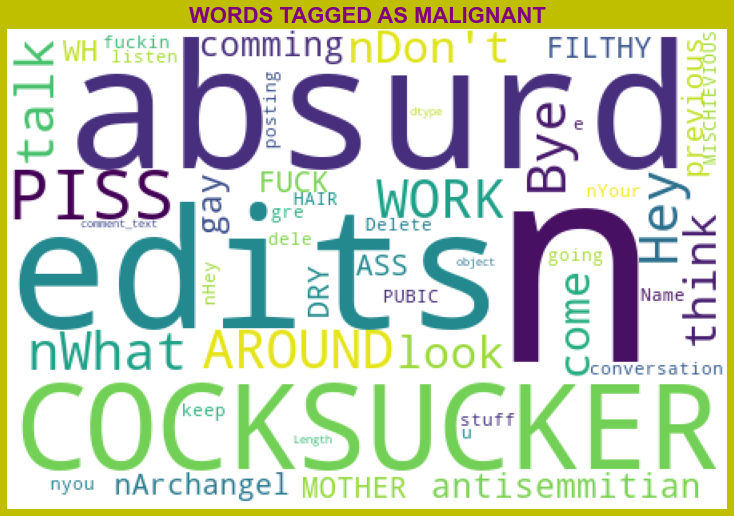

In [87]:
# Plotting for malignant
df_malignant=df[(df['malignant']==1)]
wordcloud=WordCloud(height=300,width=450,max_words=300,background_color="white").generate(str(df_malignant['comment_text']))
plt.figure(figsize=(10,10),facecolor='y')
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.title(label='WORDS TAGGED AS MALIGNANT',fontdict={'fontsize':22, 'fontweight':'bold', 'color':'purple'})
plt.show()

From wordcloud of malignant comments, it is clear that it mostly consists of words like edits, hey, white, fucking, gay, cocksucker, work, think, taliban ect.

###### Word Cloud for WORDS TAGGED AS HIGHLY MALIGNANT

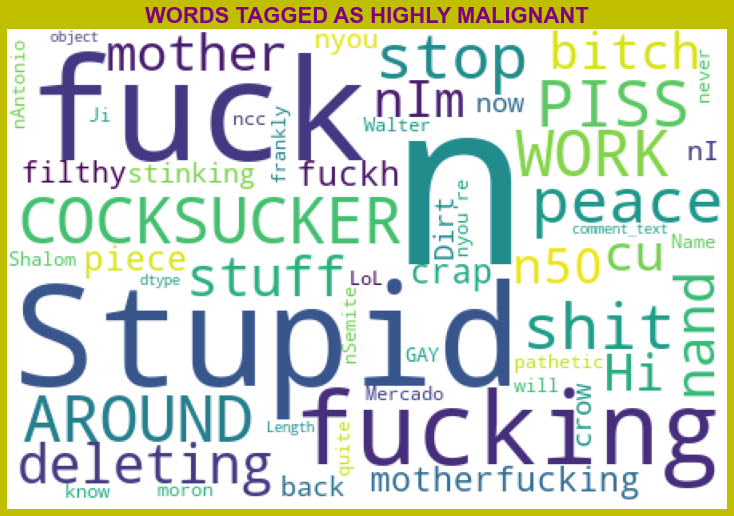

In [88]:
# Plotting for highly_malignant
df_highlymalignant=df[(df['highly_malignant']==1)]
wordcloud=WordCloud(height=300,width=450,max_words=300,background_color="white").generate(str(df_highlymalignant['comment_text']))
plt.figure(figsize=(10,10),facecolor='y')
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.title(label='WORDS TAGGED AS HIGHLY MALIGNANT',fontdict={'fontsize':22, 'fontweight':'bold', 'color':'purple'})
plt.show()

From wordcloud of Highly malignant comments, it is clear that it mostly consists of words like fuck, stupid, fucking, bitch, crow, shit, cocksucker etc.

###### Word Cloud for WORDS TAGGED AS RUDE

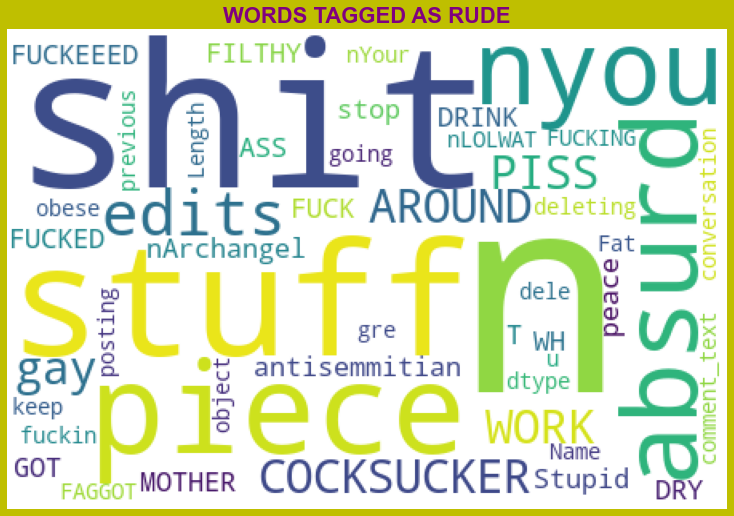

In [89]:
# Plotting for rude
df_rude=df[(df['rude']==1)]
wordcloud=WordCloud(height=300,width=450,max_words=300,background_color="white").generate(str(df_rude['comment_text']))
plt.figure(figsize=(10,10),facecolor='y')
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.title(label='WORDS TAGGED AS RUDE',fontdict={'fontsize':22, 'fontweight':'bold', 'color':'purple'})
plt.show()

From wordcloud of Rude comments, it is clear that it mostly consists of words like fucking, shit, white, piece, edits, stuff, absurd etc.

###### Word Cloud for WORDS TAGGED AS THREAT

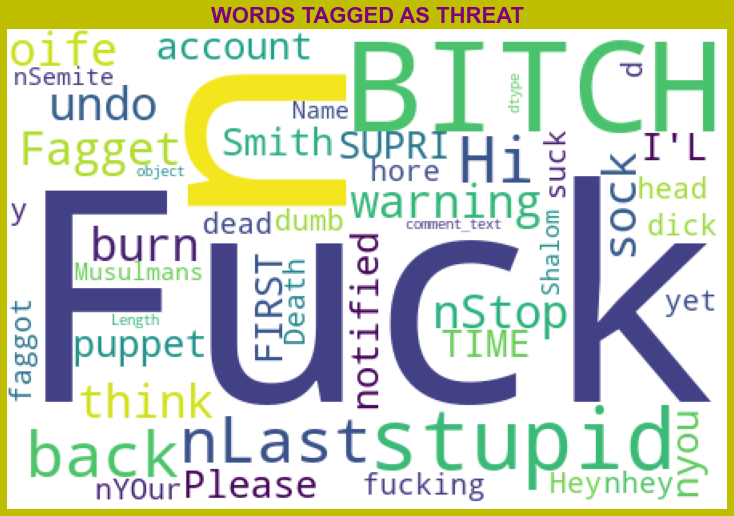

In [90]:
# Plotting for threat
df_threat=df[(df['threat']==1)]
wordcloud=WordCloud(height=300,width=450,max_words=300,background_color="white").generate(str(df_threat['comment_text']))
plt.figure(figsize=(10,10),facecolor='y')
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.title(label='WORDS TAGGED AS THREAT',fontdict={'fontsize':22, 'fontweight':'bold', 'color':'purple'})
plt.show()

From wordcloud of Threat comments, it is clear that it mostly consists of words like fuck,suck, Bitch, die, stupid, etc

###### Word Cloud for WORDS TAGGED AS ABUSE

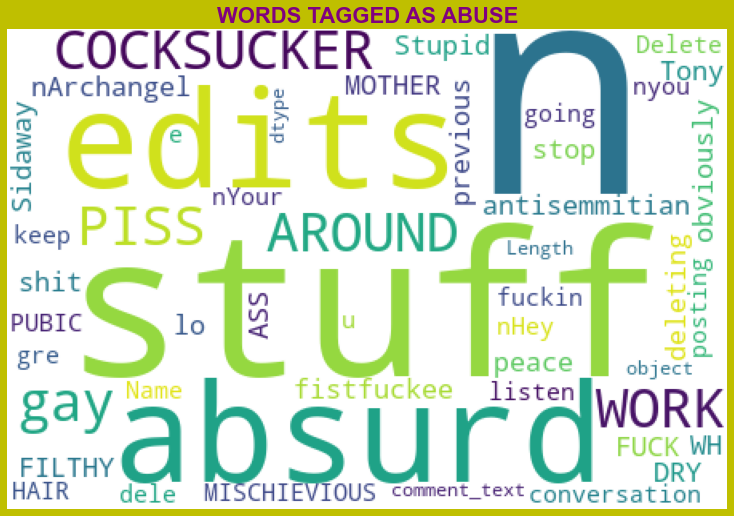

In [91]:
# Plotting for abuse
df_abuse=df[(df['abuse']==1)]
wordcloud=WordCloud(height=300,width=450,max_words=300,background_color="white").generate(str(df_abuse['comment_text']))
plt.figure(figsize=(10,10),facecolor='y')
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.title(label='WORDS TAGGED AS ABUSE',fontdict={'fontsize':22, 'fontweight':'bold', 'color':'purple'})
plt.show()

From wordcloud of Abuse comments, it is clear that it mostly consists of words like edits, white, shit, stuff, fuck, piss, fucking etc.

###### Word Cloud for WORDS TAGGED AS LOATHE

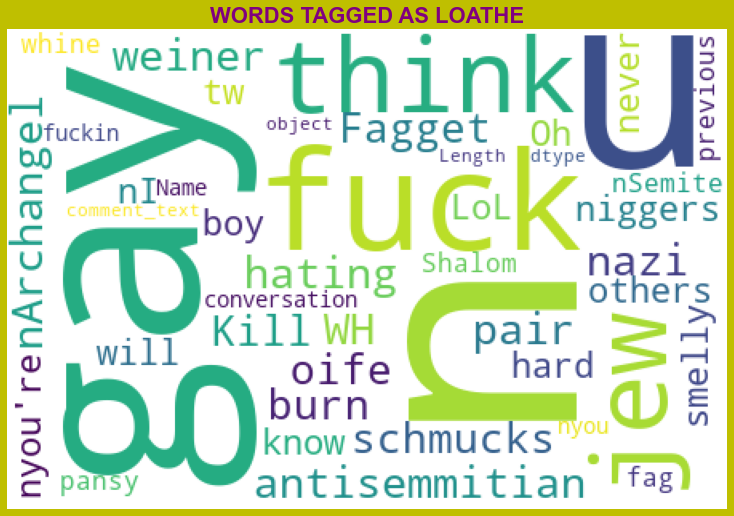

In [92]:
# Plotting for loathe
df_loathe=df[(df['loathe']==1)]
wordcloud=WordCloud(height=300,width=450,max_words=300,background_color="white").generate(str(df_loathe['comment_text']))
plt.figure(figsize=(10,10),facecolor='y')
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.title(label='WORDS TAGGED AS LOATHE',fontdict={'fontsize':22, 'fontweight':'bold', 'color':'purple'})
plt.show()

From wordcloud of Loathe comments, it is clear that it mostly consists of words like fuck,gay, kill, think, jew, u etc

###### Separating independent and dependent variables

###### 1. Vectorizer & Spliting Train dataset

In [93]:
# Converting the features into number vectors
tf_vec = TfidfVectorizer(max_features = 2000, stop_words='english')

In [94]:
# Let's Separate the input and output variables represented by X and y respectively in train data and convert them
X = tf_vec.fit_transform(df['comment_text']).toarray()

In [95]:
output_labels= df.columns[1:7]

In [96]:
# output variables
from scipy.sparse import csr_matrix
Y = csr_matrix(df[output_labels]).toarray()

# checking shapes of input and output variables to take care of data imbalance issue
print("Input Variable Shape:", X.shape)
print("Output Variable Shape:", Y.shape)

Input Variable Shape: (159571, 2000)
Output Variable Shape: (159571, 6)


###### 2. Vectorizer & Spliting Train dataset

In [97]:
# Doing the above process for test data 
test_vec = tf_vec.fit_transform(dft['comment_text'])
test_vec

<153164x2000 sparse matrix of type '<class 'numpy.float64'>'
	with 2200643 stored elements in Compressed Sparse Row format>

In [98]:
test_vec.shape

(153164, 2000)

###### Machine Learning Model Building

In [99]:
!pip install scikit-multilearn

In [100]:
#Importing Machine learning Model library
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.svm import SVC, LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import hamming_loss, log_loss

In [101]:
import timeit, sys
import tqdm.notebook as tqdm

In [102]:
# 3. Training and Testing Model on our train dataset

# Creating a function to train and test model
def build_models(models,x,y,test_size=0.33,random_state=42):
    # spliting train test data using train_test_split
    x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=test_size,random_state=random_state)
    
    # training models using BinaryRelevance of problem transform
    for i in tqdm.tqdm(models,desc="Building Models"):
        start_time = timeit.default_timer()
        
        sys.stdout.write("\n=======================================================================================\n")
        sys.stdout.write(f"Current Model in Progress: {i} ")
        sys.stdout.write("\n=======================================================================================\n")
        
        br_clf = BinaryRelevance(classifier=models[i]["name"],require_dense=[True,True])
        print("Training: ",br_clf)
        br_clf.fit(x_train,y_train)
        
        print("Testing: ")
        predict_y = br_clf.predict(x_test)
        
        ham_loss = hamming_loss(y_test,predict_y)
        sys.stdout.write(f"\n\tHamming Loss  : {ham_loss}")
                
        ac_score = accuracy_score(y_test,predict_y)
        sys.stdout.write(f"\n\tAccuracy Score: {ac_score}")
        
        cl_report = classification_report(y_test,predict_y)
        sys.stdout.write(f"\n{cl_report}")
        
        end_time = timeit.default_timer()
        sys.stdout.write(f"Completed in [{end_time-start_time} sec.]")
        
        models[i]["trained"] = br_clf
        models[i]["hamming_loss"] = ham_loss
        models[i]["accuracy_score"] = ac_score
        models[i]["classification_report"] = cl_report
        models[i]["predict_y"] = predict_y
        models[i]["time_taken"] = end_time - start_time
                      
        sys.stdout.write("\n=======================================================================================\n")
    
    models["x_train"] = x_train
    models["y_train"] = y_train
    models["x_test"] = x_test
    models["y_test"] = y_test
    
    return models

In [105]:
# Preparing the list of models for classification purpose
models = {
          "Logistic Regression": {"name": LogisticRegression()},
          "Random Forest Classifier": {"name": RandomForestClassifier()},
          "Support Vector Classifier": {"name": LinearSVC(max_iter = 3000)},
          "Ada Boost Classifier": {"name": AdaBoostClassifier()},
         }

# Taking one forth of the total data for training and testing purpose
half = len(df)//4
trained_models = build_models(models,X[:half,:],Y[:half,:])

Building Models:   0%|          | 0/4 [00:07<?, ?it/s]


Current Model in Progress: Logistic Regression 
Training:  BinaryRelevance(classifier=LogisticRegression(), require_dense=[True, True])
Testing: 

	Hamming Loss  : 0.022661096341309025
	Accuracy Score: 0.9112799088492214
              precision    recall  f1-score   support

           0       0.92      0.50      0.65      1281
           1       0.59      0.17      0.27       150
           2       0.95      0.52      0.68       724
           3       0.00      0.00      0.00        44
           4       0.81      0.42      0.56       650
           5       0.89      0.07      0.14       109

   micro avg       0.89      0.45      0.60      2958
   macro avg       0.69      0.28      0.38      2958
weighted avg       0.87      0.45      0.59      2958
 samples avg       0.05      0.04      0.04      2958
Completed in [116.67183675101842 sec.]

Current Model in Progress: Random Forest Classifier 
Training:  BinaryRelevance(classifier=RandomForestClassifier(), require_dense=[True, True

In [ ]:
Therefore I am now going to use Logistic Regression for further Hyperparameter tuning process.

# Hyperparameter Tuning

In [104]:
from sklearn.model_selection import  GridSearchCV

In [106]:
fmod_param = {'estimator__penalty' : ['l1', 'l2'],
              'estimator__loss' : ['hinge', 'squared_hinge'],
              'estimator__multi_class' : ['ovr', 'crammer_singer'],
              'estimator__random_state' : [42, 72, 111] }
#SVC = BinaryRelevance(classifier=LinearSVC(),require_dense=[True,True])           
SVC = OneVsRestClassifier(LinearSVC())
GSCV = GridSearchCV(SVC, fmod_param, cv=3,verbose = 10)
x_train,x_test,y_train,y_test = train_test_split(X[:half,:], Y[:half,:], test_size=0.30, random_state=42)
GSCV.fit(x_train,y_train)
GSCV.best_params_

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV 1/3; 1/24] START estimator__loss=hinge, estimator__multi_class=ovr, estimator__penalty=l1, estimator__random_state=42
[CV 1/3; 1/24] END estimator__loss=hinge, estimator__multi_class=ovr, estimator__penalty=l1, estimator__random_state=42;, score=nan total time= 1.4min
[CV 2/3; 1/24] START estimator__loss=hinge, estimator__multi_class=ovr, estimator__penalty=l1, estimator__random_state=42
[CV 2/3; 1/24] END estimator__loss=hinge, estimator__multi_class=ovr, estimator__penalty=l1, estimator__random_state=42;, score=nan total time=   2.0s
[CV 3/3; 1/24] START estimator__loss=hinge, estimator__multi_class=ovr, estimator__penalty=l1, estimator__random_state=42
[CV 3/3; 1/24] END estimator__loss=hinge, estimator__multi_class=ovr, estimator__penalty=l1, estimator__random_state=42;, score=nan total time=   0.9s
[CV 1/3; 2/24] START estimator__loss=hinge, estimator__multi_class=ovr, estimator__penalty=l1, estimator__random_state=7

{'estimator__loss': 'hinge',
 'estimator__multi_class': 'ovr',
 'estimator__penalty': 'l2',
 'estimator__random_state': 42}

# Final Model

In [107]:
Final_Model = OneVsRestClassifier(LinearSVC(loss='hinge', 
            multi_class='ovr', penalty='l2', random_state=42))

Classifier = Final_Model.fit(x_train, y_train)
fmod_pred = Final_Model.predict(x_test)
fmod_acc = (accuracy_score(y_test, fmod_pred))*100
print("Accuracy score for the Best Model is:", fmod_acc)
h_loss = hamming_loss(y_test,fmod_pred)*100
print("Hamming loss for the Best Model is:", h_loss)

Accuracy score for the Best Model is: 91.22660427807486
Hamming loss for the Best Model is: 2.0986519607843137


# AOC - ROC Curve of Final Model

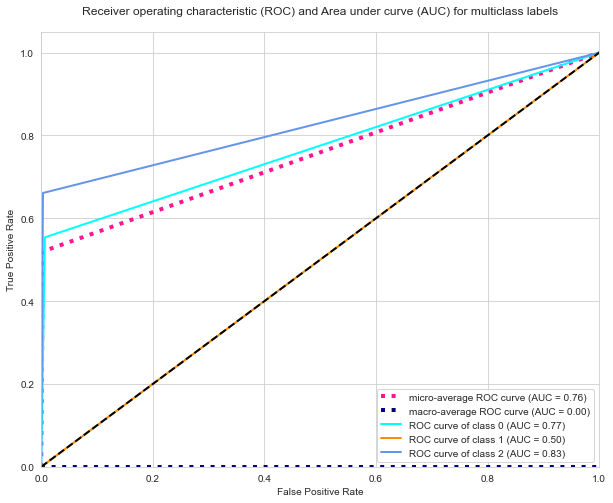

In [113]:
n_classes = y_test.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], fmod_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), fmod_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.rcParams["figure.figsize"] = (10,8) # used to change the output figure size

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))


# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (AUC = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (AUC = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = (["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=2,
        label="ROC curve of class {0} (AUC = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic (ROC) and Area under curve (AUC) for multiclass labels\n")
plt.legend(loc="lower right")
plt.show()

# Confusion Matrix of Final Model

In [114]:
from sklearn.metrics import roc_curve, auc, roc_auc_score, multilabel_confusion_matrix
print("Confusion matrix:\n\n", multilabel_confusion_matrix(y_test, fmod_pred))

Confusion matrix:

 [[[10721    72]
  [  524   651]]

 [[11833     0]
  [  135     0]]

 [[11274    36]
  [  223   435]]

 [[11930     0]
  [   38     0]]

 [[11269   103]
  [  286   310]]

 [[11871     1]
  [   89     7]]]


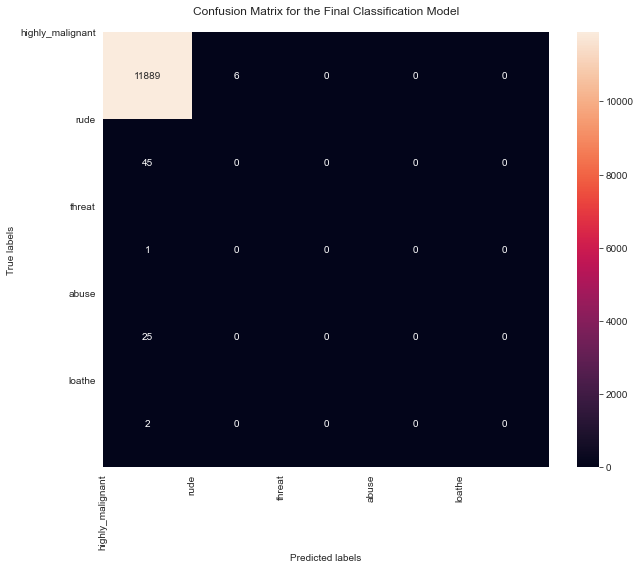

In [118]:
plt.rcParams["figure.figsize"] = (10,8) # used to change the output figure size
ax= plt.subplot()
cm = confusion_matrix(np.asarray(y_test).argmax(axis=1), np.asarray(fmod_pred).argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  # annot=True to annotate cells, ftm='g' to disable scientific notation

# title, labels and ticks
ax.set_title('Confusion Matrix for the Final Classification Model\n'); 
ax.set_xlabel('Predicted labels'); ax.set_ylabel('True labels'); 
loc = plt.MultipleLocator()
ax.xaxis.set_major_locator(loc); ax.yaxis.set_major_locator(loc);
ax.set_xticklabels(comments_labels); ax.set_yticklabels(comments_labels);
plt.xticks(rotation=90); plt.yticks(rotation=0);
plt.show()

# Model Saving or Serialization

In [119]:
# selecting the best model
best_model = trained_models['Support Vector Classifier']['trained']

# saving the best classification model
import joblib
joblib.dump(best_model,open('Malignant_comments_classifier.pkl','wb'))

# Test Dataset Predictions

In [120]:
# saving the best classification model
import joblib
best_model = joblib.load('Malignant_comments_classifier.pkl')
#joblib.dump(best_model,open('Malignant_comments_classifier.pkl','wb'))

In [121]:
test_vec.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [122]:
# Make predictions and view the results
predict_test = best_model.predict(test_vec.toarray())

# Saving predicted values into a CSV file
pd.DataFrame(predict_test).to_csv('Predicted_test_output.csv')

In [126]:
df.to_csv('test_dataset_predictions2.csv', index=False)

Finally, we had predicted over the test data and the predictions obtained were saved in a csv file.